# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm import tqdm
import random
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.
NEW FRO CHIARA : I CHANGED THE IMAGE SIZE (BECAME 128 X128) AND NUMBER OF EPOCHS FROM 100 TO 50

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync  #original was 16
IMAGE_SIZE = [128, 128]  
#EPOCHS = 50  #original was 100

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.


NEW DATA: Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is collected from several websites/hospitals/public repositories.
The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images.
All the images are resized into 128 x 128 pixels.
The Dataset has four classes of images.
The Dataset is consists of total 6400 MRI images.
Class - 1: Mild Demented (896 images)
Class - 2: Moderate Demented (64 images)
Class - 3: Non Demented (3200 images)
Class - 4: Very Mild Demented (2240 images)
Motive
The main motive behind sharing this dataset is to design/develop an accurate framework or architecture for the classification of Alzheimers Disease


CHANGE FROM: WE CREATED TRAIN AND TEST FOLDERS RESPECTING THE PROPORTION AMONG CLASSES
FOLDERS ARE CREATED ( AND FILES ARE MOVED) ONLY IF NOT PRESENT (AND IF NOT ALREADY MOVED): THE CODE, IF RUN MULTIPLE TIMES, DOES THIS ONLY ONCE

We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [3]:
# TO KEEP THE ORIGINAL PREFETCH FORMAT  AND USE KERAS PREPROCESSING FUNCTION,
# STRUCTURE DATA IN THE PROPER DIRECTORY FORMAT: PUT YOUR PATH OF THE DATASET

dataset_path = r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/"
test_size=0.2
train_path=dataset_path+"/train/" #folder doesn’t exist yet
test_path=dataset_path+"/test/"  
classes = os.listdir(dataset_path)
if 'test' in classes:
   classes.remove('test')
if 'train' in classes:
  classes.remove('train')
print(classes)  # if train / test folders not created (first time running code), 'test' and  'train' not present

# Create folders (if not present) for test and training set
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


if os.path.isdir(train_path):
   print('Dataset has already been splitted and saved into train, validation and test data')
else:
    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)  # train path containing one class
        test_class_path = os.path.join(test_path, class_name)  # test path containing one class


        #  Get the list of files in that class
        files = os.listdir(class_path)

        # Create a folder (inside training and test folder) for each class
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)


        # Divide dataset of the class in training set and test set
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)


        # Move training files (train_files) just created in the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file).replace('\\','/')
            dst_path = os.path.join(train_path, class_name, file).replace('\\','/')
            if file not in dst_path:
             shutil.copyfile(src_path, dst_path)


        # Move test files (test_files) just created in the test folder
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            if file not in dst_path:
             shutil.copy(src_path, dst_path)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Dataset has already been splitted and saved into train, validation and test data


In [4]:
trainval_cnt = sum([len(files) for _, _, files in os.walk(train_path)])
test_cnt = sum([len(files) for _, _, files in os.walk(test_path)]) # might use this in case of using different batch size for test set
validation_split = 0.2
BATCH_SIZE = round(trainval_cnt * validation_split * 0.1)
print("Batch Size for train and val set:", BATCH_SIZE)

Batch Size for train and val set: 102


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,  
)

Found 5118 files belonging to 4 classes.
Using 4095 files for training.
Found 5118 files belonging to 4 classes.
Using 1023 files for validation.


In [6]:
class_names=classes
train_ds.class_names = classes
val_ds.class_names = classes

NUM_CLASSES = len(class_names)

MildDemented class has 716 samples
ModerateDemented class has 51 samples
NonDemented class has 2560 samples
VeryMildDemented class has 1791 samples


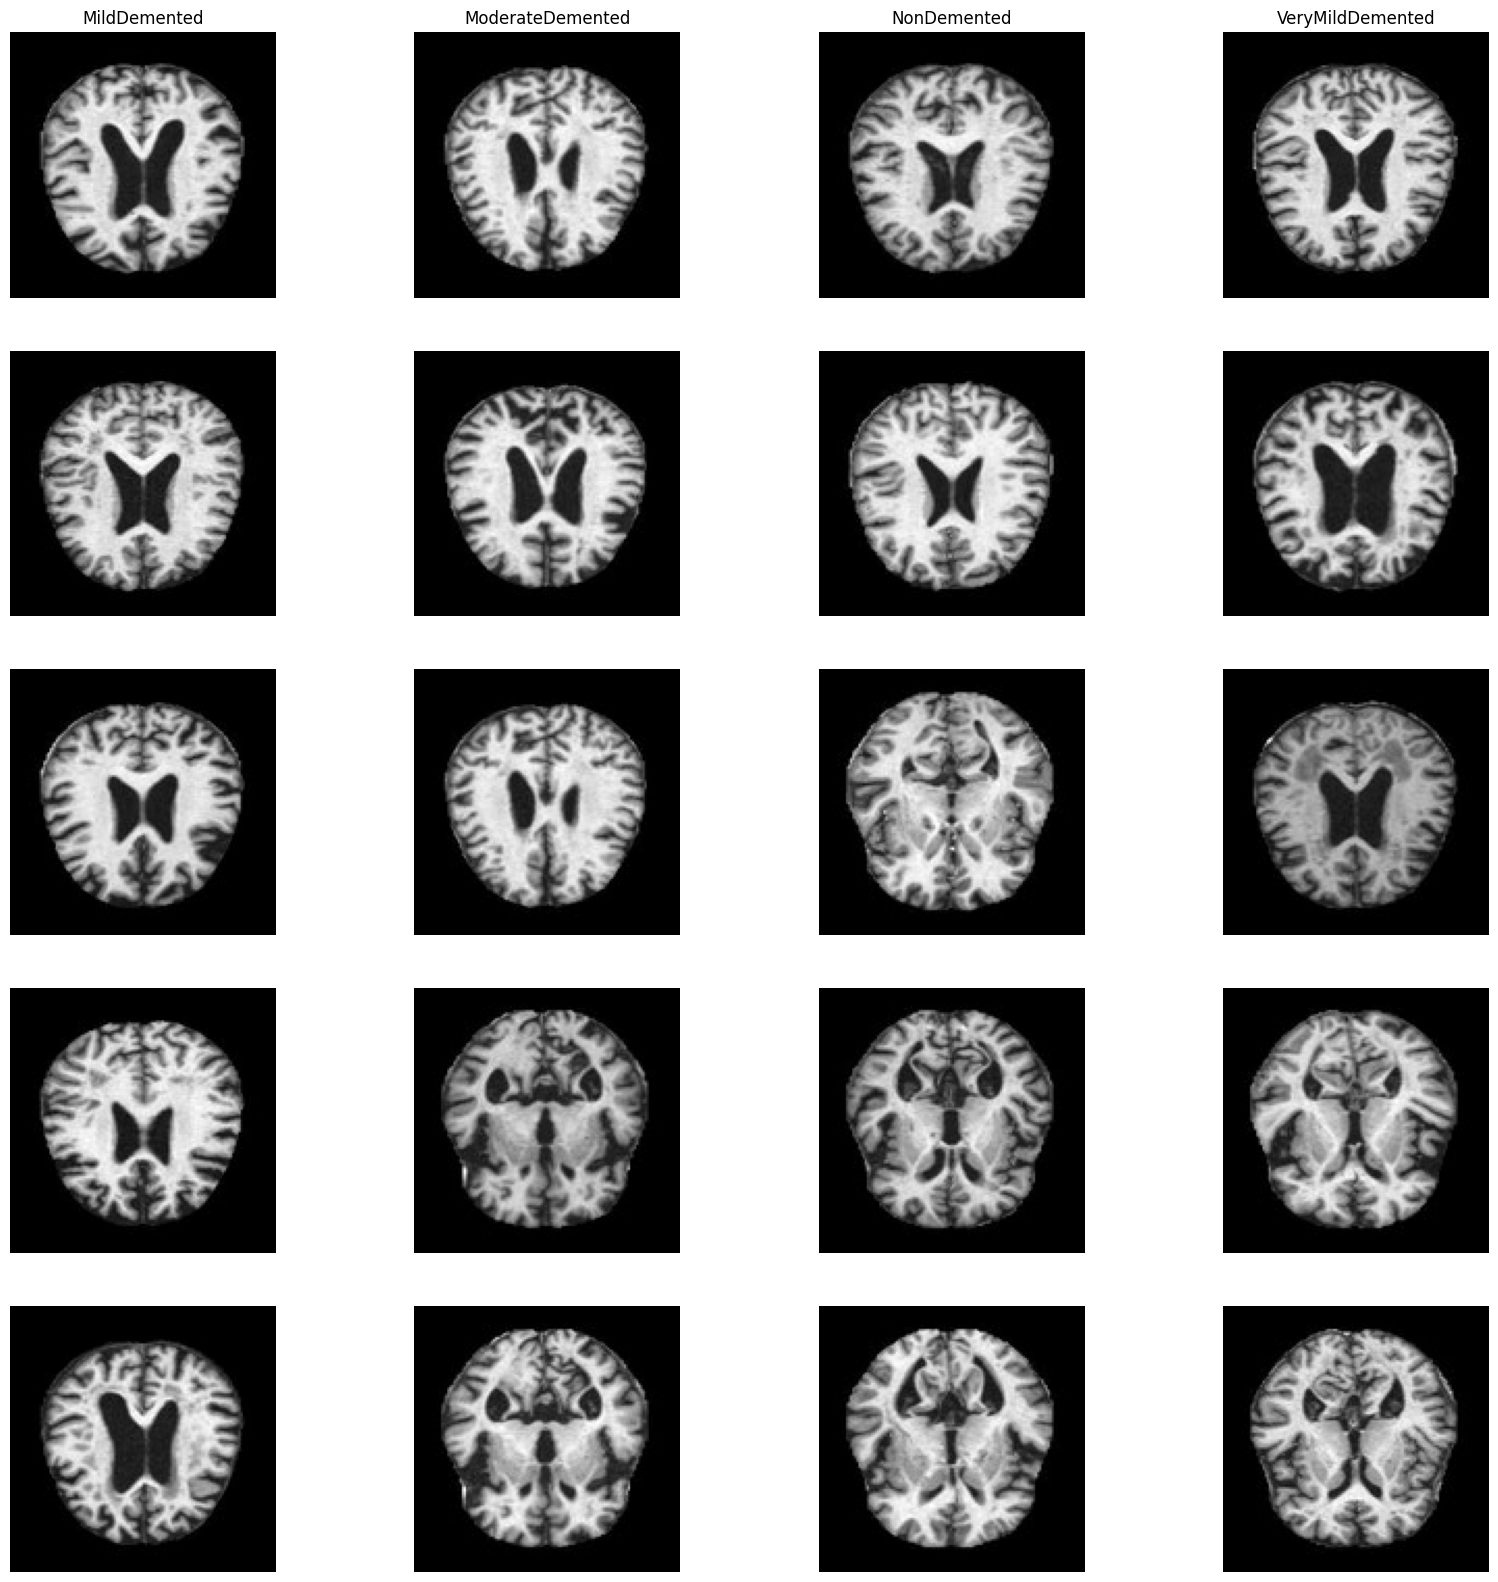

In [7]:
imgs = {c: glob(join(train_path, c, "*")) for c in classes}
# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder


for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        gray_im=im.convert('L')
        axs[n,i].imshow(gray_im,cmap='gray')
for ax in axs.flatten():
    ax.axis("off")



# SHOW THEM IN bLACK AND WHITE??



ORIGINAL CODE: Change class names 

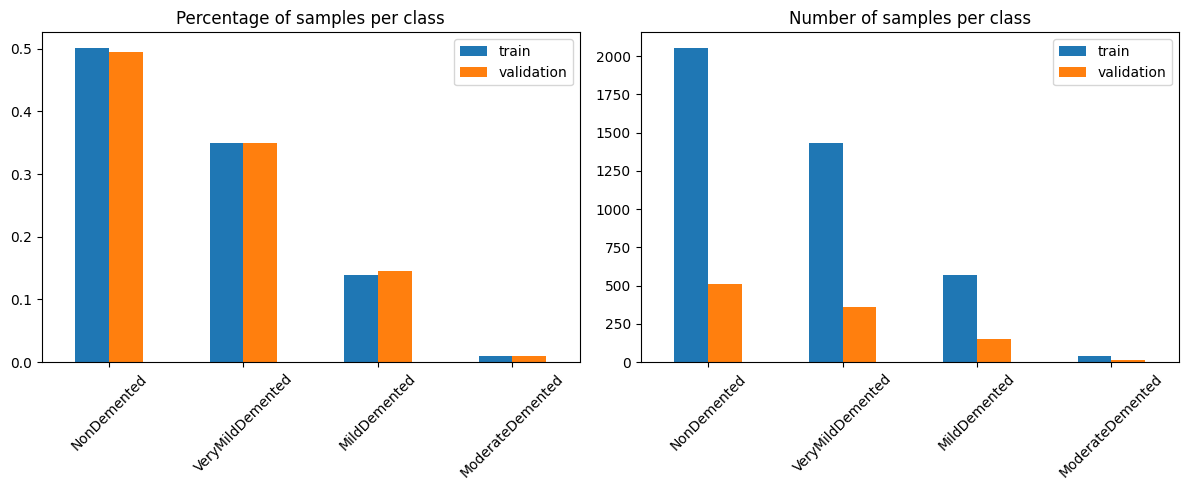

<Figure size 640x480 with 0 Axes>

In [8]:
train_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')

In [9]:
NUM_IMAGES_PRE = []

for label in class_names:
    dir_name = r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/"+label
    num=len([name for name in os.listdir(dir_name)])
    NUM_IMAGES_PRE.append(num)
    print("{} class has {} samples in training set".format(label,num))



MildDemented class has 716 samples in training set
ModerateDemented class has 51 samples in training set
NonDemented class has 2560 samples in training set
VeryMildDemented class has 1791 samples in training set


Keep in mind that the choice of the test batch size depends on the characteristics of your data and the requirements of your evaluation process. The code you provided aims to find a reasonable batch size that is a divisor of ts_length and not greater than 80. If this meets your needs, then it should work for its intended purpose.

CHANGE-->Efficiency and Performance Optimization: In some cases, using a custom function for test data batch size can lead to more efficient data processing or better utilization of available resources, especially when dealing with unconventional data structures or sources.

#Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Write down number of samples for each class by counting  number of files for each folder
To do this, build a dictionary where  keys are folder names (-> the 4 classes) and values are the filenames for the files in each folder.

In [10]:

# check how the images are loaded
# (float in [0,1] or uint in [0,255])

#TAKE ONE IMAGE
#Xs = (list(train_ds.take(1)))
#X=Xs[0][1]
#print("Image dtype ="    , type(X))
#print("Min pixel value =", X.min())
#print("Max pixel value =", X.max())
#print("Shape =", X.shape)


# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [11]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

 The function changes data representation in an "easier" way:  converts the label into a one-hot encoded tensor (one-hot representation with a depth of NUM_CLASSES) using TensorFlow's tf.one_hot function, and returns the original image along with its one-hot encoded label. Many deep learning models can operate only on numeric variables for the algorythm efficiency [citation 2]. For categorical variables for which no ordinal relationship exists, as these, the integer encoding is not enough. One hot encoding  converts categorical data to numbers before fitting the model: a new binary variable (column) is added to the dataset for each unique categorical value in the variable (the presence or absence of a "1" in a column indicates the class of the input sample) and the original categorical variable is removed from the dataset ; this avoids introducing ordinal relationships between labels because they are treated as distinct and unrelated;    here this works well since target only has 4 possible values  [SLIDE PROF ?]. One more reason to apply this function is that many loss functions, such as categorical cross-entropy [citation 3]  expect the target labels to be in one-hot encoded format. 







In [12]:
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [13]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [14]:

def labels_fromPrefetch(test_ds):
    #  Function to extract labels from a Prefetch Dataset 
    # Get y_true labels
    test_ds_it=test_ds.as_numpy_iterator() #Numpy iterator
    true_labels = []  # Lista per le etichette reali

    for batch in test_ds_it:
        # Assumiamo che ogni batch contenga etichette reali e previste
        true_batch,true_batch_labels = batch  # Sostituisci con la chiave corretta
        # Aggiungere le etichette del batch alle liste
        true_labels.extend(true_batch_labels)

    y_true_onehot = np.vstack(true_labels)
    y_true=np.argmax(y_true_onehot,axis=1)
    return y_true



def observations_fromPrefetch(train_ds):
    iterator = iter(train_ds)
    all_tensors=[]
    while True:
        try:
            batch_x, batch_y = iterator.get_next()
            all_tensors.append((batch_x))
        except tf.errors.OutOfRangeError:
            # End of the dataset
            break
    return all_tensors

# Now  all_tensors contains all tensors from your Prefetch Dataset

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

DATA AUGMENTATION FOR BALANCING CLASSES INSPIRING TO THE PAPER A Deep Siamese Convolution Neural Network for Multi-Class Classification of Alzheimer Disease  (Chiara 6).
In neuroimaging, a large number of scans related to AD patient’s availability are a major issue
because few hundreds of image samples are available. It is a common thing for a deep learning model
to provide more effective results on more data. In medical research, due to privacy concerns, the access
to large data is a big problem [47], especially, the classification of cancer and AD are problematic due to
lack of availability of data. The small imbalanced dataset creates overfitting problems during training
of the model which affects the model efficiency. To overcome this issue, we need more data to enhance
the effective accuracy in our proposed model. We used the augmentation technique to create 10 more
images on each available MRI image [48]. In Table 3, data augmentation is described for the parameters
used for augmentation.


Define layers for data augmenatation inside the model

In [15]:
RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(0.1, 0.3),
    width_factor=(0.1, 0.3),
    fill_mode="constant",
    seed=2023
))

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)

RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)


The following cell is a function that saves the image, or the augmented image, that it receives as first input and puts it inside the folder given to 

In [47]:
def save_augmented_image(image,i,label,folderto,transf=""):
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  filename = f"image_{i}_label_{label}_{transf}.jpg"  # Use a counter or other identifiers        # Create a unique filename or use some identifier based on your datase
  image_path = os.path.join(folderto, filename).replace("\\","/")  # Specify the complete path for saving the image
  tf.keras.preprocessing.image.save_img(image_path, image_array)          # Save the image using a suitable library like PIL or OpenCV

def rescale_im(im):
  min_value = np.min(im)
  max_value = np.max(im)
  scaled_im = (im - min_value) / (max_value - min_value)
  return scaled_im


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


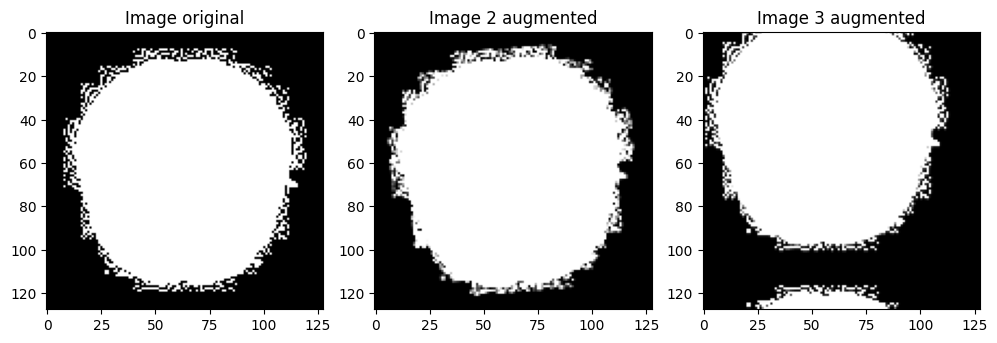

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


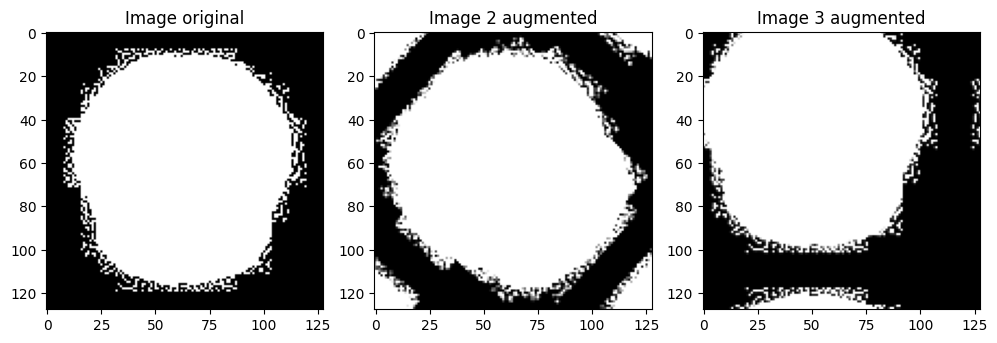

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


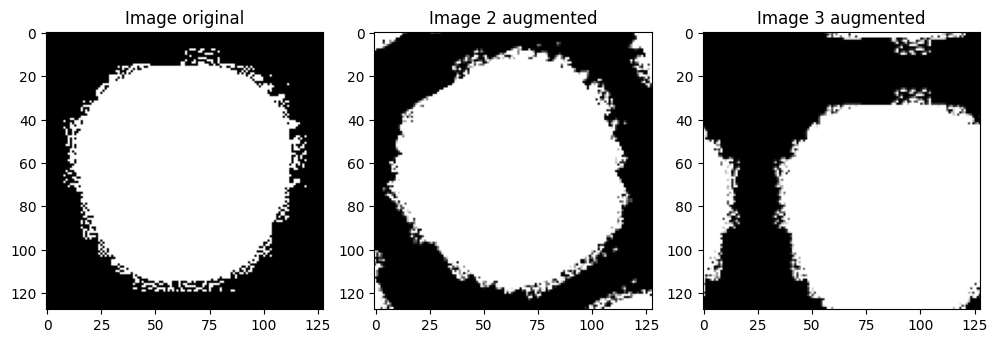

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


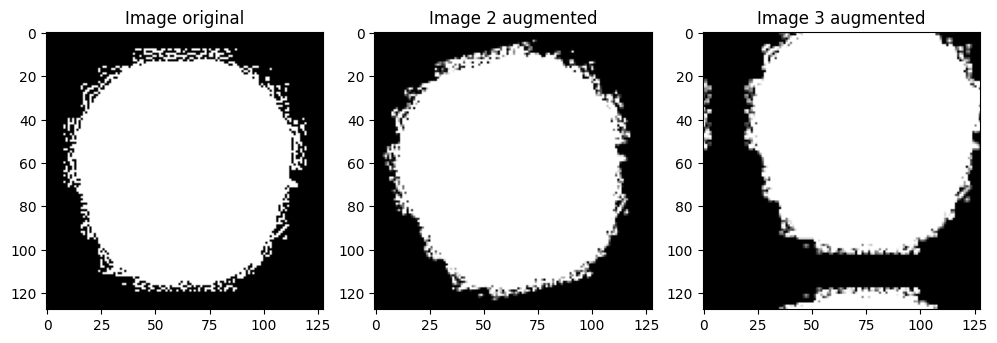

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


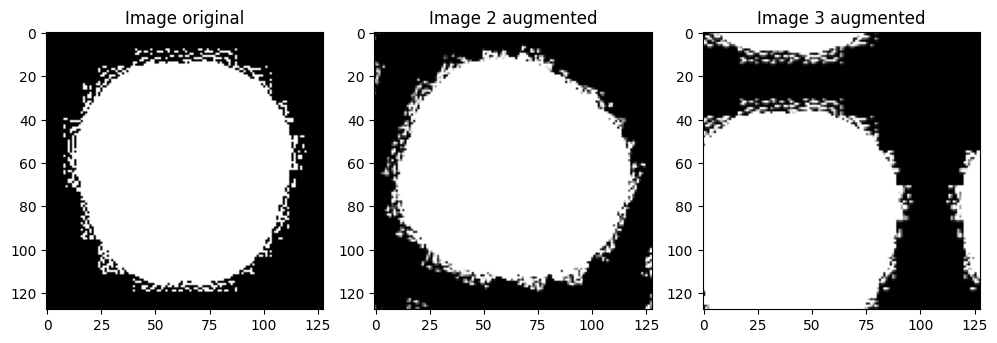

In [46]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)

#EXTRACT LABELS
import random
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS 
tensors_train=observations_fromPrefetch(train_ds)  #list of 41 4D tensorflows tensors (102,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 41 4D arrays  (102,128,128,3)
s=list_of_arrays[0].shape  # (102,128,128,3)

images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays

example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]


augmented_images = []
augmented_labels = []
folder_augmented_0=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[0]+"/"
folder_augmented_1=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[1]+"/"
folder_augmented_2=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[2]+"/"
folder_augmented_3=r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+class_names[3]+"/"

folders_augmented=[folder_augmented_0,folder_augmented_1,folder_augmented_2,folder_augmented_3]
for f in folders_augmented:
 if not os.path.exists(f):
        os.makedirs(f)
 [os.unlink(os.path.join(f, file)) for file in os.listdir(f) if os.path.isfile(os.path.join(f, file))]


# SHOW FOR THE FIRST 12 ITERATIONS, ONE IMAGE AND ITS AUGMENTED

 # Delete files augmented previously, if  present
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

     # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor 
        augmented_image2= RandomTranslation_layer1(image)
        #augmented_image3=RandomZoom_layer1(image) 
                                         
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])    
        
        # SAVE image and augmented
        save_augmented_image(image,i,label,folder_augmented_0)
        save_augmented_image(augmented_image,i,label,folder_augmented_0,transf="RandRot")
        save_augmented_image(augmented_image2,i,label,folder_augmented_0,transf="RandTrasl")
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

       #for augmented_image in augmented_image2_list:
    
       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image3_list:
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image4_list:
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]


       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)

       # SAVE IMAGE  +
       save_augmented_image(image,i,label,folder_augmented_1,transf="RandRot"+str(n))
       n=1
       for im in augmented_image_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandRot"+str(n))
         n+=1
       n=1
       for im in augmented_image2_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandTrasl"+str(n))
         n+=1
       n=1
       for im in augmented_image3_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandZoom"+str(n))     
         n+=1
       n=1
       for im in augmented_image4_list:
         save_augmented_image(im,i,label,folder_augmented_1,transf="RandFlip"+str(n))  
         n+=1
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
       #augmented_images_conc =augmented_image
       save_augmented_image(augmented_image,i,label,folder_augmented_2)
    if label == 3: 
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
            augmented_image=RandomRotation_layer1(image)
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 
            save_augmented_image(image,i,label,folder_augmented_3)
            save_augmented_image(augmented_image,i,label,folder_augmented_3,transf="RandRot")
        else:
            augmented_image=image
            augmented_images_conc=augmented_image
            save_augmented_image(augmented_image,i,label,folder_augmented_3)
       
    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)
    if i<=20 and num_tensors!=1:  #augmented_images_conc contains the original image and the augmented ones
      fig, axs = plt.subplots(nrows=1, ncols=num_tensors, figsize=(10, 10))
      for k in range(num_tensors):
        imtoshow=(augmented_images_resh[k]).numpy()
        imtoshow=rescale_im(imtoshow) #values 0-1
        axs[k].imshow(imtoshow)  # Replace with your actual image plotting code
        if k==0:
           axs[k].set_title(f"Image original")
        else:
          axs[k].set_title(f"Image {k + 1} augmented")
        # Add a list below each image
        #axs[k].text(0.5, -0.15, '\n'.join(imtoshow), transform=axes[i].transAxes, ha='center', va='top')   
      # Adjust layout for better spacing
      plt.tight_layout()
      # Show the plot
      plt.show()

    for el in augmented_images_resh:
       augmented_images.append(el)
    for ss in range(len(augmented_images_resh)):
       augmented_labels.append(label)



In [44]:
sb0=np.count_nonzero(example[:,:,1]!=example[:,:,2]) #0
sb02=np.count_nonzero(example[:,:,1]!=example[:,:,0]) #0 
# it's a tensor with three same channels

maxvalue=np.max(example)
minvalue=np.min(example)
medvalue=np.mean(example)

In [39]:
number_of02=augmented_labels.count(0)  #568= Class 1 : Mild Demented-->  1704 Mild Demented
number_of12=augmented_labels.count(1)  #41= Class  2: Moderate Demented (64 images)-->1681 Moderate Demented
number_of22=augmented_labels.count(2)  #2053= Class 3: Non Demented (3200 images)--> 2053  Non Demented
number_of32=augmented_labels.count(3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1860 Very Mild Demented

NUM_IMAGES_POST = []

for label in class_names:
    dir_name_augmented= r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Augmented_TrainDataset/"+label+"/"
    num=len([name for name in os.listdir(dir_name_augmented)])
    print("{} class has {} samples in training set, after data augmentation".format(label,num))
    NUM_IMAGES_POST.append(num)

NUM_IMAGES_POST

MildDemented class has 1704 samples in training set, after data augmentation
ModerateDemented class has 1680 samples in training set, after data augmentation
NonDemented class has 2053 samples in training set, after data augmentation
VeryMildDemented class has 1861 samples in training set, after data augmentation


[1704, 1680, 2053, 1861]

In [20]:
def Prefetch_fromLO(test_labels,test_observations,batch_size=BATCH_SIZE):
    test_labels_np = np.array(test_labels)
    test_observations_np = np.array(test_observations)

    # Create a tf.data.Dataset from the list
    #predictions_tensor = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None])
    #features_tensor = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None] + list(test_observations_np.shape[1:]))
    dataset = tf.data.Dataset.from_tensor_slices((test_observations_np,  test_labels_np))
    
    # Apply prefetching
    prefetch_dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Apply any additional transformations or mappings here
    # For example, if you want to one-hot encode the labels, you can use map:
    prefetch_dataset = prefetch_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
    prefetch_dataset= prefetch_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Batch the dataset
    prefetch_dataset = prefetch_dataset.batch(batch_size)

    return prefetch_dataset


In [21]:
train_ds_aug=Prefetch_fromLO(augmented_labels,augmented_images)

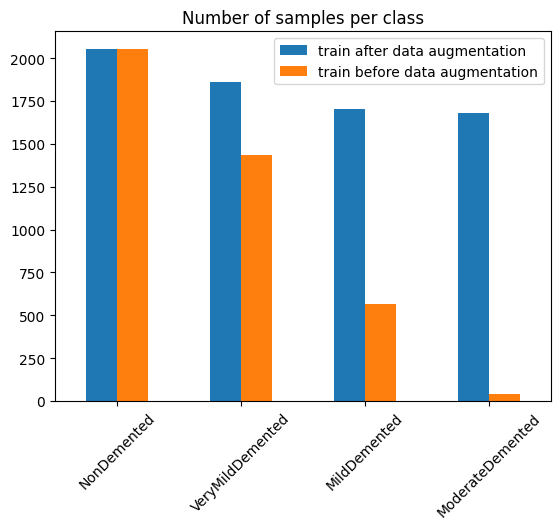

In [22]:

train_labels_names=['MildDemented' if el==0 else 'ModerateDemented' if el==1 else 'NonDemented'  if el==2 else 'VeryMildDemented'   for el in augmented_labels]
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_names).value_counts(normalize=vis_ratio), pd.Series(train_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train after data augmentation', 'train before data augmentation'])
plt.savefig('Data augmentation results')

In [23]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [24]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [25]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

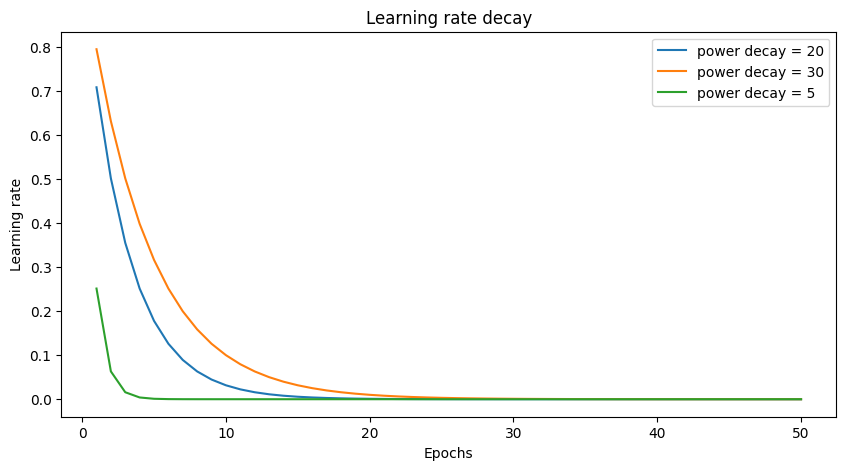

In [26]:
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

plt.savefig('Learning_Rate_Decay.png')

# comment on CHOICE OF LEARNING RATES




For example then: 
model.load_weights(checkpoint_filepath) # The model weights (that are considered the best) are loaded into the  model.

In [27]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS=100
with strategy.scope():
    model = build_model()
    plot_model(model, show_shapes=True)
    METRICS = [tf.keras.metrics.AUC(name='auc')]
    model.summary()
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )
exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)         
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

# Save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
##checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    #save_best_only=True)  

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#save_best_only=True   #  keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.



#early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     #restore_best_weights=True)  # VALIDATION LOSS


#stops training if a monitored metric (in this case, validation loss) does not improve after a certain number of epochs (patience).
# patience=  Number of epochs with no improvement after which training will be stopped.
# restore_best_weights=True --> Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 32, 32, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 64)        7392      
                                     

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 103s 2s/step - loss: 13.9860 - auc: 0.6414 - val_loss: 12012023.0000 - val_auc: 0.5849 - lr: 1.0000
Epoch 2/100
41/41 [==============================] - 96s 2s/step - loss: 3.7157 - auc: 0.7219 - val_loss: 206234.7031 - val_auc: 0.5810 - lr: 0.7079
Epoch 3/100
28/41 [===================>..........] - ETA: 31s - loss: 2.1446 - auc: 0.7537

KeyboardInterrupt: 

We have plotted different time decays for learning rate, assuming for example 50 epochs, to see how it decreases with epochs.
The parametres from the original code 


Let's fit our model!

In [ ]:
#batch_size = 40   # set batch size for training
#epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(trainval_cnt / BATCH_SIZE))    # number of training batch to run per epoch

callbacks_new = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold, batches= batches, epochs= EPOCHS, ask_epoch= ask_epoch,factor=factor )]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks= [callbacks_new],
    epochs=EPOCHS
)

#consider SHUFFLE:   
# NON è CROSS VALIDATION: DA PROVARE!

Do you want model asks you to halt the training [y/n] ?


In [ ]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model = build_model_tunable(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

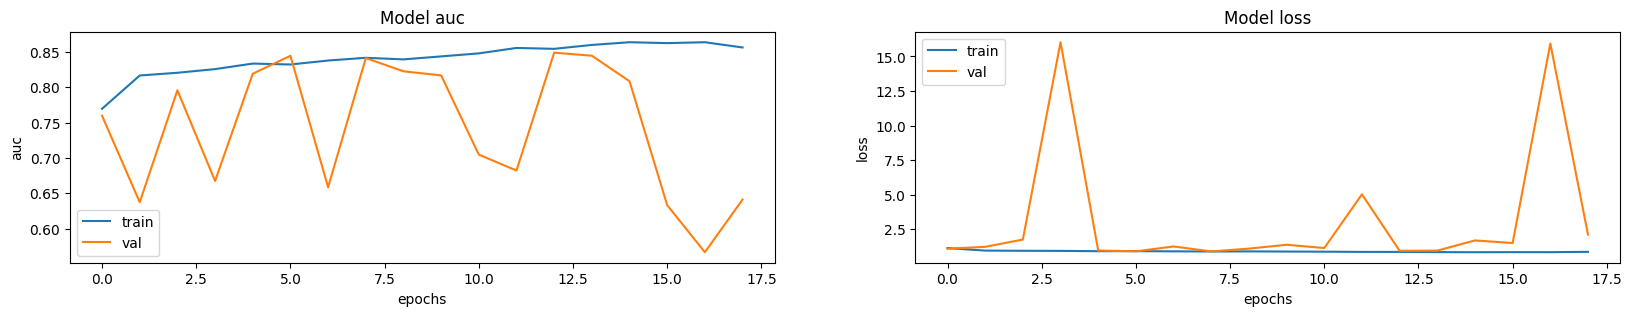

In [ ]:

# Cohen's Kappa
kappa_metric = tfa.metrics.CohenKappa(num_classes=NUM_CLASSES,name='cohen_kappa')

# SpecificityAtSensitivity (specificity at a given sensitivity), computes best specificity where sensitivity is >= specified value.
specificity_at_sensitivity = tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.8, num_thresholds=200, class_id=None, name='specificity_at_sensitivity', dtype=None)

# Recall (calculates the recall (sensitivity) of a model)
recall = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name='recall', dtype=None)
fig, ax = plt.subplots(1, 7, figsize=(20, 3))
ax = ax.ravel()

# add acc,f1,cohen,recall,sensitivity at specificity
for i, met in enumerate(['auc', 'loss', 'accuracy', 'f1','cohen_kappa','recall','specificity_at_sensitivity']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    fig, ax = plt.subplots(ncols=2,figsize=(20, 3))


plt.suptitle('Performance Metrics of Original Model')

plt.savefig('Original_model.png')


h=history.history
mett=h.keys()


"""
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')

plt.savefig('Original_model.png')
"""


I  ALSO ADDED AUC PLOT 
TO ADD : BALANCED ACCURACY ?

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1282 files belonging to 6 classes.


#PRINT METRICS

In [ ]:
# TO EVALUATE TOGETHER
#ts_length = len(test_df)
#test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
#test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)



print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


33/33 [==============================] - 9s 253ms/step - loss: 0.4203 - auc: 0.9712
Train Loss:  0.037956174463033676
Train Accuracy:  0.9998902082443237
--------------------
Validation Loss:  0.38499557971954346
Validation Accuracy:  0.9762882590293884
--------------------
Test Loss:  0.42034441232681274
Test Accuracy:  0.971248984336853


Print balanced accuracy ( IF WE BALANCE CLASSES NOT NECESSARY!)

In [ ]:
train_labels=labels_fromPrefetch(train_ds)
train_predictions = model.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1) # Convert predictions to class labels
balanced_acc_train = balanced_accuracy_score(train_labels, train_pred_labels)

print("Balanced Accuracy Training Set:", balanced_acc_train)


val_labels=labels_fromPrefetch(val_ds)
val_predictions = model.predict(val_ds)
val_pred_labels = np.argmax(val_predictions, axis=1) # Convert predictions to class labels
balanced_acc_val = balanced_accuracy_score(val_labels, val_pred_labels)

print("Balanced Accuracy Validation Set:", balanced_acc_val)


test_labels=labels_fromPrefetch(val_ds)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1) # Convert predictions to class labels
balanced_acc = balanced_accuracy_score(test_labels, y_pred)

print(y_pred)
print("Balanced Accuracy Test Set:", balanced_acc)

DEFINE A FUNCTION TO PLOT CONFUSION MATRIX

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')
	




33/33 [==============================] - 8s 233ms/step
[0 3 3 ... 2 2 2]


NameError: name 'test_gen' is not defined

Print confusion matrix and some metrics

In [57]:
# Get y_true labels
y_true=labels_fromPrefetch(test_ds)

model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))

NameError: name 'preds' is not defined